In [1]:
import itertools
import pandas as pd
from sqlalchemy import create_engine
import pymysql
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager as fm
from matplotlib import rc
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import sys, os, time
from glob import glob
warnings.filterwarnings(action='ignore')
mpl.rcParams['axes.unicode_minus'] = False
font_path = 'C:/font/malgun.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
print(font_name)
rc('font', family=font_name)

endpoint = 'dao.c51deksujiip.ap-northeast-2.rds.amazonaws.com'
schema = 'dao'
db_connection_str = 'mysql+pymysql://admin:ekfkawnl@{}/{}'.format(endpoint, schema)
try :
    db_connection = create_engine(db_connection_str)
    conn = db_connection.connect()
except :
    print('fail to connect db')

def load_data_from_rds(tabel_name):
  sql = "SELECT * FROM {}".format(tabel_name)
  df = pd.read_sql(sql, db_connection)
  return df

Malgun Gothic


In [2]:
# sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(__file__))))

from preprocessing.preprocessing_func import preprocess_df

In [3]:
def plot_confusion_matrix(cm, target_names=None, cmap=None, normalize=True, labels=True, title='Confusion matrix'):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names)
        plt.yticks(tick_marks, target_names)

    if labels:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            if normalize:
                plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
            else:
                plt.text(j, i, "{:,}".format(cm[i, j]),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [4]:
def random_forest_result(df, file_name, feature_importance = False, optimizing = False):
    train_x, test_x, train_y, test_y = train_test_split(df.drop('생태통로_효율성', axis=1), df['생태통로_효율성'], test_size=0.2, stratify=df['생태통로_효율성'])
    rf_clf = RandomForestClassifier()
    if optimizing :
        parameters = {
            'n_estimators': range(10, 50, 10),
            'max_depth' : range(1, 10, 2),
            'min_samples_split': range(1, 10, 2),
            'min_samples_leaf': [1, 3, 5],
        }
        start = time.time()
        # Random Forest
        grid_cv = GridSearchCV(rf_clf, param_grid=parameters, n_jobs=-1, scoring='accuracy', cv=5)
        grid_cv.fit(train_x, train_y)
        print('GridSearch 수행시간 : ', time.time()-start)
        print('최적 하이퍼 파라미터 :',grid_cv.best_params_)
        best_cv = grid_cv.best_estimator_

        # GridSearchCV의 최적 하이퍼파라미터로 학습된 Estimator로 예측 및 평가 수행
        pred = best_cv.predict(test_x)
        rf_clf = best_cv
    else:
        rf_clf.fit(train_x, train_y)
        pred = rf_clf.predict(test_x)

    print('정확도 : ', accuracy_score(pred, test_y))
    print('f1 score :', f1_score(y_true=test_y, y_pred=pred, average=None))
    print('f1 score average :', f1_score(y_true=test_y, y_pred=pred, average='macro'))

    # 혼동행렬
    cm =confusion_matrix(test_y, pred)
    plot_confusion_matrix(cm, target_names=list(df['생태통로_효율성'].unique()), cmap='Blues', title='{} confusion matrix'.format(file_name))

    if feature_importance :
        importances = rf_clf.feature_importances_
        std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_], axis=0)
        indices = np.argsort(importances)[::-1]

        print('Feature Ranking:')
        for f in range(train_x.shape[1]) :
            print('{}. feature {} ({:3f})'.format(f+1, train_x.columns[indices][f], importances[indices[f]]))
            if f == 10 :
              break

        plt.title('Feature importances')
        plt.bar(range(train_x.shape[1]), importances[indices],
                color='r', yerr=std[indices])
        plt.xlim([-1, train_x.shape[1]])
        plt.xticks(rotation=45)
        plt.show()

In [5]:
overpass_list = glob('.././data/MainData_cases/*overpass*.csv')
overpass_list = [p.replace('\\', '/') for p in overpass_list]
print(overpass_list)
tunnel_list = glob('.././data/MainData_cases/*tunnel*.csv')
tunnel_list = [p.replace('\\', '/') for p in tunnel_list]
print(tunnel_list)

['.././data/MainData_cases/overpass_knn1_drop.csv', '.././data/MainData_cases/overpass_knn1_median.csv', '.././data/MainData_cases/overpass_knn2_drop.csv', '.././data/MainData_cases/overpass_knn2_median.csv', '.././data/MainData_cases/overpass_knn3_drop.csv', '.././data/MainData_cases/overpass_knn3_median.csv', '.././data/MainData_cases/overpass_knn4_drop.csv', '.././data/MainData_cases/overpass_knn4_median.csv', '.././data/MainData_cases/overpass_knn5_drop.csv', '.././data/MainData_cases/overpass_knn5_median.csv', '.././data/MainData_cases/overpass_mean_drop.csv', '.././data/MainData_cases/overpass_mean_median.csv']
['.././data/MainData_cases/tunnel_knn1_drop.csv', '.././data/MainData_cases/tunnel_knn1_median.csv', '.././data/MainData_cases/tunnel_knn2_drop.csv', '.././data/MainData_cases/tunnel_knn2_median.csv', '.././data/MainData_cases/tunnel_knn3_drop.csv', '.././data/MainData_cases/tunnel_knn3_median.csv', '.././data/MainData_cases/tunnel_knn4_drop.csv', '.././data/MainData_cases

In [10]:
onehot_col = ['지형기호(2.3km)', '최우점식물군락']
scaling_col = ['폭(m)', '연장(m)', '주변 로드킬 빈도', '산책로까지의 최단 거리(km)', '농가까지의 거리(km)', '도로 최고제한속도(km/h)',
               '하천거리(km)', '주변 동물종 개수', '등산로까지 최단거리(km)', '유도울타리_연장_m', '유도울타리_높이_m', '교통량', '건물까지거리(km)']
drop_col = ['번호', '위도', '경도', '생태통로_유형', '이용확인종_수', '유도울타리_위도_2.3km', '유도울타리_경도_2.3km', '식물군락명']
scaling_col_tunnel = scaling_col + ['높이(m)', '개방도']

# 육교형

GridSearch 수행시간 :  24.826996326446533
최적 하이퍼 파라미터 : {'max_depth': 9, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 30}
정확도 :  0.5135135135135135
f1 score : [0.61538462 0.46153846 0.36363636]
f1 score average : 0.48018648018648014


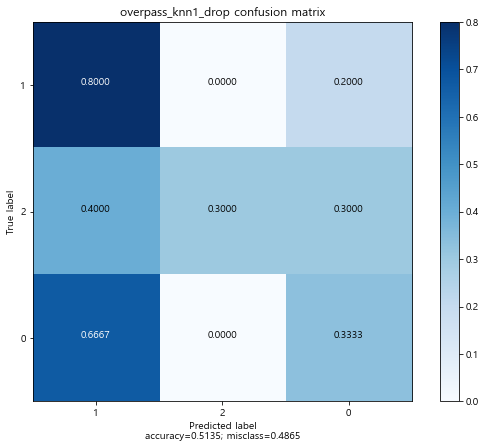

GridSearch 수행시간 :  17.596009254455566
최적 하이퍼 파라미터 : {'max_depth': 1, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 20}
정확도 :  0.6333333333333333
f1 score : [0.57692308 0.82142857 0.        ]
f1 score average : 0.46611721611721607


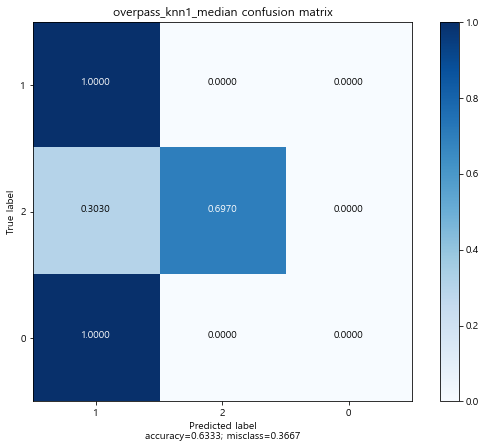

GridSearch 수행시간 :  16.94899892807007
최적 하이퍼 파라미터 : {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 20}
정확도 :  0.2702702702702703
f1 score : [0.3902439  0.         0.21052632]
f1 score average : 0.20025673940949937


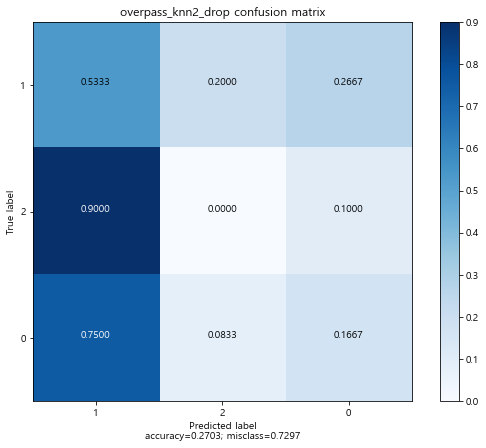

GridSearch 수행시간 :  17.309540271759033
최적 하이퍼 파라미터 : {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 3, 'n_estimators': 20}
정확도 :  0.55
f1 score : [0.4        0.73684211 0.34782609]
f1 score average : 0.49488939740655985


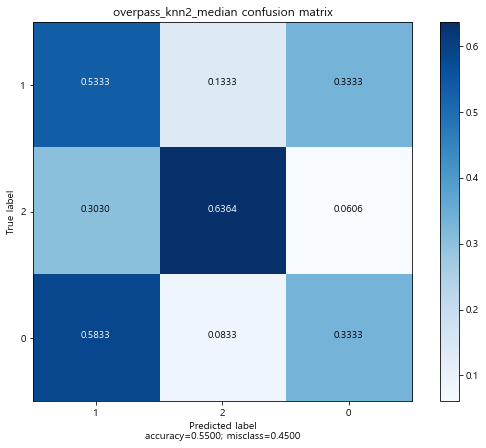

GridSearch 수행시간 :  16.962970495224
최적 하이퍼 파라미터 : {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 10}
정확도 :  0.32432432432432434
f1 score : [0.51428571 0.         0.25      ]
f1 score average : 0.2547619047619048


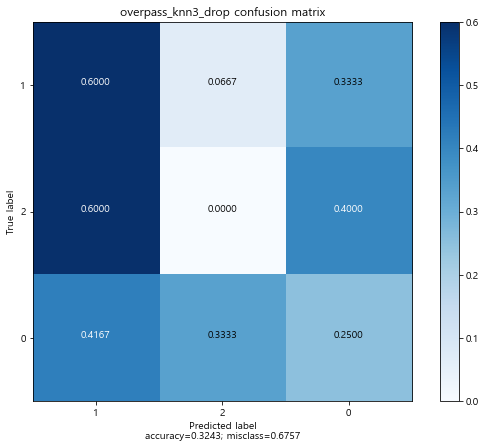

GridSearch 수행시간 :  17.11500334739685
최적 하이퍼 파라미터 : {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 20}
정확도 :  0.7
f1 score : [0.57142857 0.92307692 0.2       ]
f1 score average : 0.5648351648351648


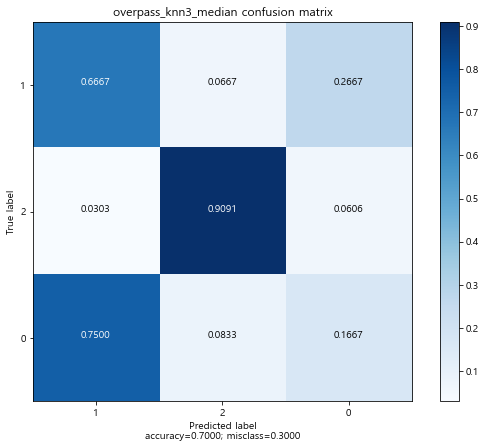

GridSearch 수행시간 :  17.21196961402893
최적 하이퍼 파라미터 : {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 20}
정확도 :  0.35135135135135137
f1 score : [0.46511628 0.14285714 0.23529412]
f1 score average : 0.2810891798579897


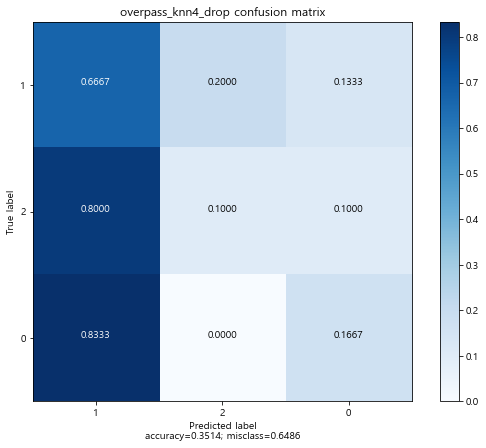

GridSearch 수행시간 :  19.218003511428833
최적 하이퍼 파라미터 : {'max_depth': 9, 'min_samples_leaf': 5, 'min_samples_split': 9, 'n_estimators': 30}
정확도 :  0.6333333333333333
f1 score : [0.60465116 0.73684211 0.4       ]
f1 score average : 0.5804977560179517


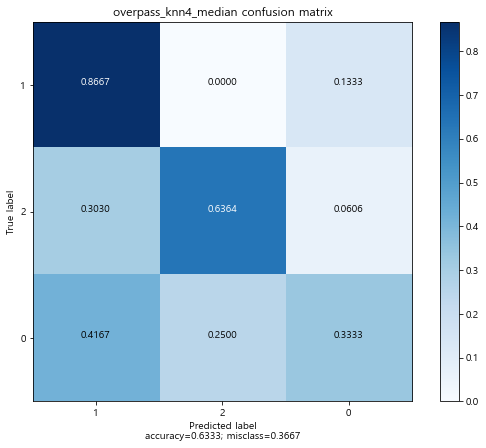

GridSearch 수행시간 :  17.632997035980225
최적 하이퍼 파라미터 : {'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 40}
정확도 :  0.40540540540540543
f1 score : [0.48648649 0.30769231 0.33333333]
f1 score average : 0.3758373758373758


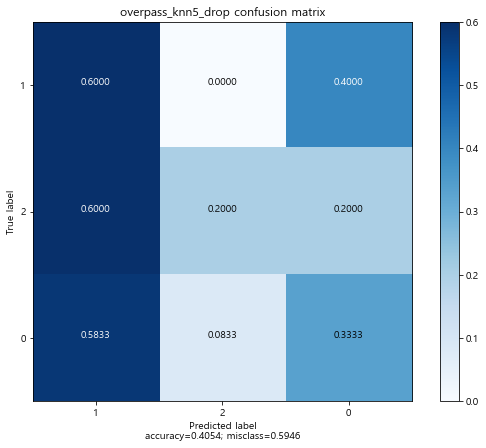

GridSearch 수행시간 :  17.299993991851807
최적 하이퍼 파라미터 : {'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 7, 'n_estimators': 40}
정확도 :  0.6
f1 score : [0.27586207 0.79411765 0.43478261]
f1 score average : 0.5015874415733309


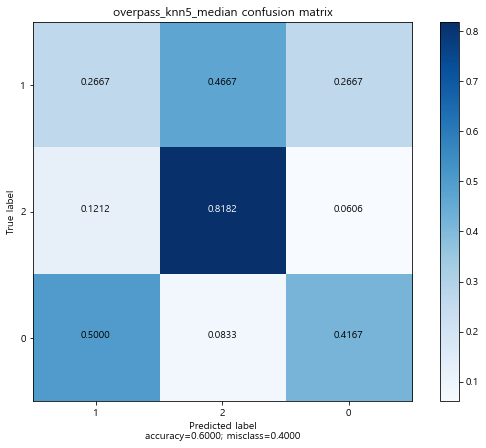

GridSearch 수행시간 :  18.51496934890747
최적 하이퍼 파라미터 : {'max_depth': 1, 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 10}
정확도 :  0.43243243243243246
f1 score : [0.58823529 0.         0.15384615]
f1 score average : 0.2473604826546003


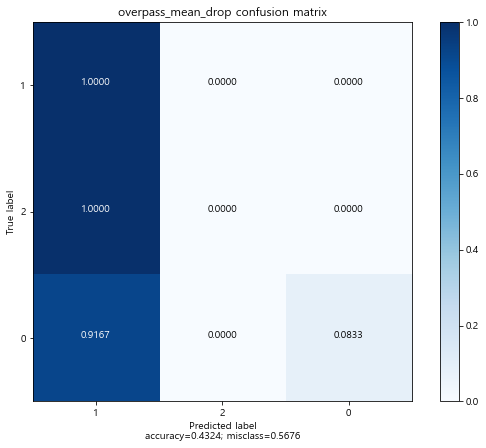

GridSearch 수행시간 :  18.108999729156494
최적 하이퍼 파라미터 : {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 20}
정확도 :  0.6833333333333333
f1 score : [0.625      0.86666667 0.        ]
f1 score average : 0.4972222222222222


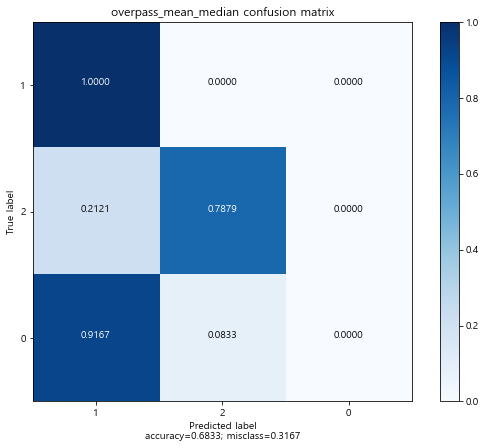

In [11]:
for case in overpass_list :
    df = pd.read_csv(case, encoding='cp949')
    name = case.split('/')[-1].split('.')[0]
    # print(df.columns)
    df = preprocess_df(df, drop_col=drop_col, labeling_col=onehot_col, scaling_col=scaling_col, scaling_func=StandardScaler)
    # print(df.columns)
    random_forest_result(df, file_name=name, optimizing=True)


# 터널형

GridSearch 수행시간 :  15.706997394561768
최적 하이퍼 파라미터 : {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 40}
정확도 :  0.56
f1 score : [0.59259259 0.         0.66666667]
f1 score average : 0.419753086419753


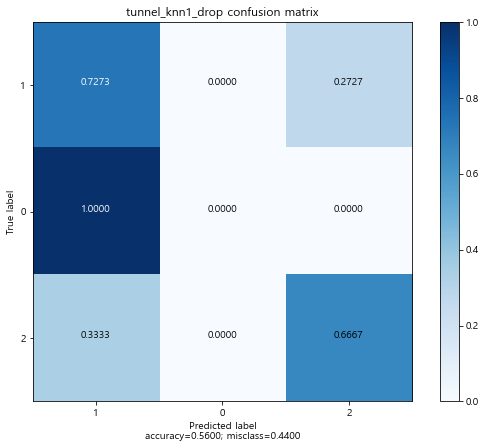

GridSearch 수행시간 :  15.982964515686035
최적 하이퍼 파라미터 : {'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 9, 'n_estimators': 30}
정확도 :  0.725
f1 score : [0.64       0.88888889 0.52631579]
f1 score average : 0.6850682261208577


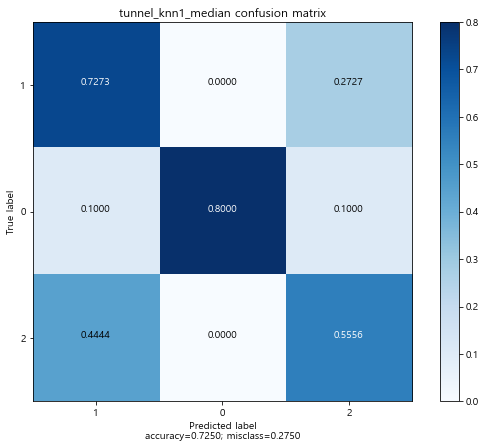

GridSearch 수행시간 :  16.689974069595337
최적 하이퍼 파라미터 : {'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 30}
정확도 :  0.52
f1 score : [0.66666667 0.         0.44444444]
f1 score average : 0.3703703703703704


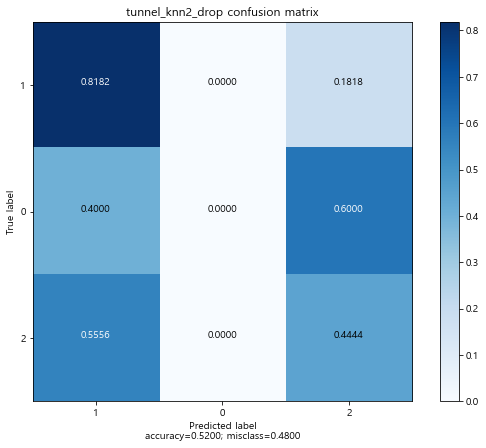

GridSearch 수행시간 :  16.712997436523438
최적 하이퍼 파라미터 : {'max_depth': 9, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 30}
정확도 :  0.725
f1 score : [0.58333333 0.88888889 0.6       ]
f1 score average : 0.6907407407407408


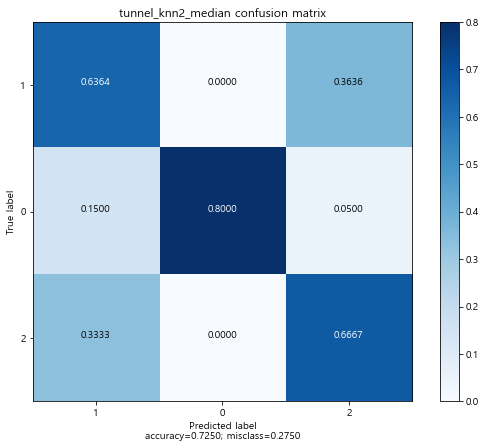

GridSearch 수행시간 :  18.302001237869263
최적 하이퍼 파라미터 : {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 7, 'n_estimators': 40}
정확도 :  0.64
f1 score : [0.72727273 0.66666667 0.52631579]
f1 score average : 0.6400850611376927


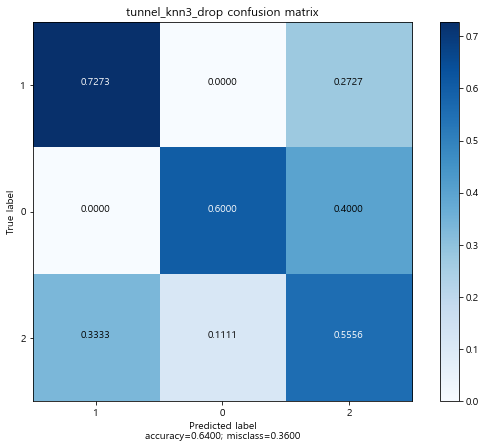

In [ ]:
for case in tunnel_list :
    df = pd.read_csv(case, encoding='cp949')
    name = case.split('/')[-1].split('.')[0]
    # print(df.columns)
    df = preprocess_df(df, drop_col=drop_col, labeling_col=onehot_col, scaling_col=scaling_col_tunnel, scaling_func=StandardScaler)
    # print(df.columns)
    random_forest_result(df, file_name=name, optimizing=True)
